In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn import *
import math 
import random
import itertools


In [32]:
# data
L=64
B=1000
d=3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1.0 / tf.sqrt(in_dim / 2.0)
    return tf.random_normal(shape=size, stddev=xavier_stddev)



def log2(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(2, dtype=numerator.dtype),)
    return numerator / denominator

def func(x):
    return x


def gen_X():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_X,
                                  size = [B, L,L])


def gen_Y(X):
    return func(X)+ np.random.multivariate_normal( mean=meu, cov=eta_N, size =  [B, L,L])



In [33]:
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))

In [34]:
x.shape

(1000, 64, 64, 3)

In [35]:
def ma(array, policy,window_size=None, beta=None):
    x=np.zeros(len(array))
    if policy=='window':
        for i in range(0, len(array)):
            if i<window_size:
                x[i]= np.mean(array[0: i])
            else:
                x[i]= np.mean(array[i-window_size: i])
    elif policy=='weighted':
        x[0]=array[0]
        for i in range(1, len(array)):
               x[i]=x[i-1]*(1-beta)+beta*array[i]
    elif policy=='None':
        for i in range(1, len(array)):
             x[i]=array[i] 
    return x


In [36]:
def MINE(x, y):

    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer())
    Wout=tf.Variable(xavier_init( [128,1]))
    bout=tf.Variable(tf.zeros([1]))

    x_shuffle=tf.random_shuffle(x)
    y_shuffle=tf.random_shuffle(y)
    
    In = tf.concat([x, y], axis=2)

    
    In_shuffle = tf.concat([x, y_shuffle], axis=2)


    layer_joint1 = tf.nn.relu(tf.nn.conv2d(In, W1, strides=[1, 1, 1, 1], padding='SAME'))
    layer_jointP1 = tf.nn.max_pool(layer_joint1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    
    layer_marg1 = tf.nn.relu(tf.nn.conv2d(In_shuffle, W1, strides=[1, 1, 1, 1], padding='SAME'))
    layer_margP1 = tf.nn.max_pool(layer_marg1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')

    layer_joint2 =tf.nn.relu(tf.nn.conv2d(layer_jointP1, W2, strides=[1, 1, 1, 1], padding='SAME'))
    layer_jointP2 = tf.nn.max_pool(layer_joint2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')

    layer_marg2 =tf.nn.relu(tf.nn.conv2d(layer_margP1, W2, strides=[1, 1, 1, 1], padding='SAME'))
    layer_margP2 = tf.nn.max_pool(layer_marg2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')

    
    layer_joint3= tf.contrib.layers.flatten(layer_jointP2)
    layer_marg3= tf.contrib.layers.flatten(layer_margP2)
    
    
    out_joint=abs(tf.matmul(layer_joint3,Wout)+bout)
    out_marg=abs(tf.matmul(layer_marg3,Wout)+bout)
   
    
    lower_bound=(tf.reduce_mean(out_joint,axis=0)-log2(tf.reduce_mean(tf.math.pow(2.0,out_marg),axis=0)+10e-5))

    theta = [W1,W2 ,Wout, bout]

    opt = tf.train.AdamOptimizer(0.01).minimize((-lower_bound), var_list=[theta])


    return lower_bound, opt

In [37]:
   
    
    tf.reset_default_graph()
    # prepare the placeholders for inputs
    x_in = tf.placeholder(tf.float32, [B,L,L,d], name='x_in')
    y_in = tf.placeholder(tf.float32, [B,L,L,d], name='y_in')
    # make the loss and optimisation graphs
    lower_bound, train_step= MINE(x_in, y_in)

    # start the session
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    # train
    MIs = []

    n_epochs = 2000
   



    for epoch in range(n_epochs):

        # generate the data
        x_sample=gen_X()
        y_sample=gen_Y(x_sample)


        # perform the training step 
        feed_dict = {x_in:x_sample, y_in:y_sample}
        low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
       # print (te)
        # save the loss
        MIs.append(low_bnd)
        print(epoch/n_epochs*100, end='\r')
  
    mv_av=ma(MIs, policy='weighted', beta=0.01)

    m=list(mv_av)
    cMI=max(m)
    error=((cMI-mi)/mi)*100


    op = open("CNN.txt","a") 

    op.write( ' True value: {:.4} ; calculated value: {:.4}; error: {:.4}%; Average:{:.4}% \n'
    .format(mi, cMI, error, np.mean(error))) 
    op.close() 
    sess.close()
              


C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


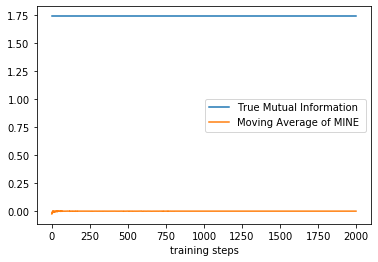

In [38]:
fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av)), MIs, label='Moving Average of MINE ')

ax.set_xlabel('training steps')
ax.legend
(loc='best')
fig.savefig('CNN.png')
fig.show()